In [185]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split

### Preprocessing Steps:

- remove duplicate
- missing values
- Scaling
- outliers,
- categorical tretment => encoding


### Read the data

In [186]:
data = pd.read_csv("employee_compensation.csv")
data

# Total_Compensation is the target variable

,Year_Type,Year,Employee_Identifier,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health/Dental,Other_Benefits,Total_Benefits,Total_Compensation
0,Fiscal,2015,42853,92288.22,267.45,267.45,92823.12,20700.20,12500.56,7605.75,40806.51,133629.63
1,Calendar,2015,28248,1466.38,348.23,0.00,1814.61,0.00,442.03,141.59,583.62,2398.23
2,Fiscal,2014,30651,76536.95,13583.72,10855.94,100976.61,18632.19,12464.61,8011.41,39108.21,140084.82
3,Fiscal,2014,19473,45659.88,0.00,1625.37,47285.25,10081.20,0.00,3936.63,14017.83,61303.08
4,Fiscal,2013,7176,41832.00,0.00,0.00,41832.00,7617.60,5908.52,3254.50,16780.62,58612.62
...,...,...,...,...,...,...,...,...,...,...,...,...
49995,Fiscal,2016,1629,100222.50,17166.13,600.00,117988.63,18763.05,13068.80,9406.86,41238.71,159227.34
49996,Fiscal,2014,35471,1787.41,0.00,0.00,1787.41,0.00,563.31,145.36,708.67,2496.08
49997,Fiscal,2016,42176,36552.83,0.00,0.00,36552.83,6802.48,6855.83,3071.63,16729.94,53282.77
49998,Fiscal,2016,10980,46995.30,0.00,10943.14,57938.44,8840.98,10624.64,4706.37,24171.99,82110.43


In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Year_Type            50000 non-null  object 
 1   Year                 50000 non-null  int64  
 2   Employee_Identifier  50000 non-null  int64  
 3   Salaries             50000 non-null  float64
 4   Overtime             50000 non-null  float64
 5   Other_Salaries       50000 non-null  float64
 6   Total_Salary         50000 non-null  float64
 7   Retirement           50000 non-null  float64
 8   Health/Dental        50000 non-null  float64
 9   Other_Benefits       50000 non-null  float64
 10  Total_Benefits       50000 non-null  float64
 11  Total_Compensation   50000 non-null  float64
dtypes: float64(9), int64(2), object(1)
memory usage: 4.6+ MB


In [188]:
# Remove duplicate

# checking duplicate data
data[data.duplicated()]

# No Duplicates so no need to remove duplicate

# if there is a dupicate, drop them using below code
data.drop_duplicates(inplace=True)

In [189]:
data = data[~data["Total_Compensation"].isnull()]

# I am only allowing missing values in features

In [190]:
# delete Employee_Identifier, since it dont add any value on Total Compensation
try:
  data.drop(columns=["Employee_Identifier"], axis=1, inplace=True)
except:
  pass

In [191]:
# Find y, x_cat, x_num


# target variable
y = data["Total_Compensation"]
print(y)

features = data.drop(["Total_Compensation"], axis=1)


# categorical
x_categorical = features.select_dtypes("object")
print(x_categorical)

# numerical
x_numerical = features.select_dtypes(["float", "int"])
# x_numerical = data.select_dtypes("number")

print(x_numerical)



0        133629.63
1          2398.23
2        140084.82
3         61303.08
4         58612.62
           ...    
49995    159227.34
49996      2496.08
49997     53282.77
49998     82110.43
49999    104354.49
Name: Total_Compensation, Length: 50000, dtype: float64
      Year_Type
0        Fiscal
1      Calendar
2        Fiscal
3        Fiscal
4        Fiscal
...         ...
49995    Fiscal
49996    Fiscal
49997    Fiscal
49998    Fiscal
49999    Fiscal

[50000 rows x 1 columns]
       Year   Salaries  Overtime  ...  Health/Dental  Other_Benefits  Total_Benefits
0      2015   92288.22    267.45  ...       12500.56         7605.75        40806.51
1      2015    1466.38    348.23  ...         442.03          141.59          583.62
2      2014   76536.95  13583.72  ...       12464.61         8011.41        39108.21
3      2014   45659.88      0.00  ...           0.00         3936.63        14017.83
4      2013   41832.00      0.00  ...        5908.52         3254.50        16780.62
...    

In [192]:
# Missing values

data.isna().isnull().sum() # no null values

# if you find any null values
# numeric - fill with mean
for col in x_numerical.columns:
  mean = x_numerical[col].mean()
  x_numerical[col] = x_numerical[col].fillna(mean)

# categorical - fill with mode
for col in x_categorical.columns:
  mode = x_categorical[col].mode()[0]
  x_categorical[col] = x_categorical[col].fillna(mode)



In [193]:
# Scaling (Apply only on numerical variables)
# Y and x_cat can't scale

scaler = StandardScaler() # OR MIN MAX SCALLER
array = scaler.fit_transform(x_numerical)

x_numerical_scalled = pd.DataFrame(array, columns = x_numerical.columns)

In [194]:
x_numerical_scalled

,Year,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health/Dental,Other_Benefits,Total_Benefits
0,0.655605,0.648711,-0.369318,-0.456896,0.411551,0.791779,0.733109,0.779354,0.850626
1,0.655605,-1.377872,-0.362028,-0.492153,-1.329400,-1.317047,-1.723024,-1.189758,-1.537735
2,-0.313537,0.297240,0.832431,0.938928,0.567523,0.581102,0.725787,0.886371,0.749784
3,-0.313537,-0.391746,-0.393454,-0.277889,-0.459567,-0.290028,-1.813059,-0.188593,-0.740037
4,-1.282679,-0.477161,-0.393454,-0.492153,-0.563886,-0.541006,-0.609586,-0.368545,-0.575987
...,...,...,...,...,...,...,...,...,...
49995,1.624747,0.825755,1.155732,-0.413058,0.892955,0.594433,0.848851,1.254503,0.876290
49996,-0.313537,-1.370709,-0.393454,-0.492153,-1.329920,-1.317047,-1.698321,-1.188763,-1.530310
49997,1.624747,-0.594959,-0.393454,-0.492153,-0.664874,-0.624046,-0.416634,-0.416787,-0.578996
49998,1.624747,-0.361948,-0.393454,0.950423,-0.255777,-0.416375,0.351014,0.014472,-0.137101


<Axes: >

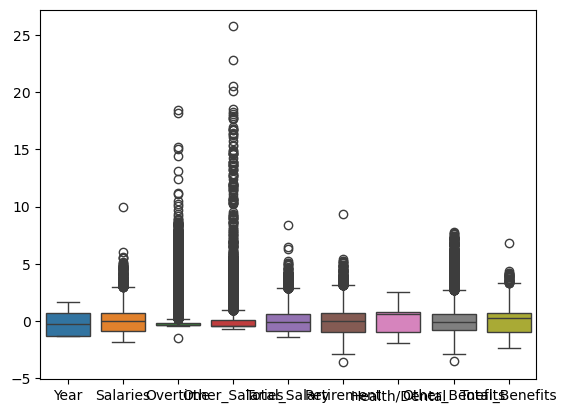

In [195]:
import seaborn as sns
sns.boxplot(x_numerical_scalled)

In [196]:
# fix outliers

def refill(number, upper_limit, lower_limit):

  if number > upper_limit:
    return upper_limit
  elif number < lower_limit:
    return lower_limit
  else:
    return number

for col in x_numerical_scalled.columns:
  q1 = np.quantile(x_numerical_scalled[col], 0.25)
  q3 = np.quantile(x_numerical_scalled[col], 0.75)
  
  iqr = q3 - q1 # IQR (Interquartile Range)

  lower_limit = q1 - 1.5 * iqr
  upper_limit = q3 + 1.5 * iqr

  x_numerical_scalled[col] = x_numerical_scalled[col].apply(lambda x: refill(x, upper_limit, lower_limit))

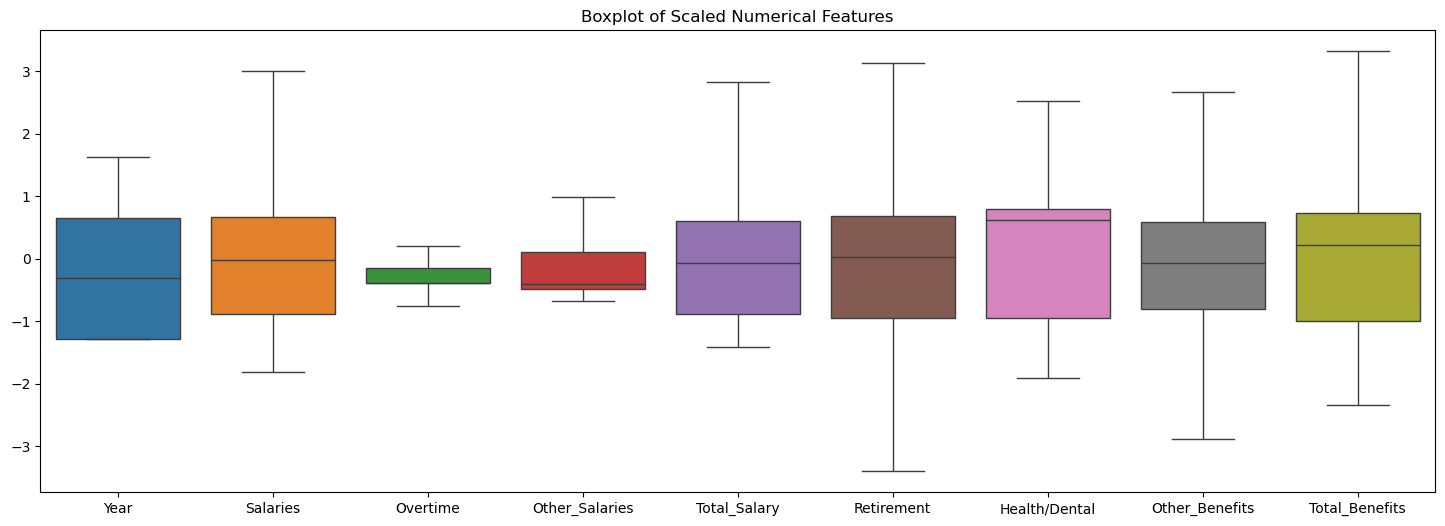

In [197]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))  # Increase figure size
sns.boxplot(data=x_numerical_scalled)
# plt.xticks(rotation=45)      # Rotate x-axis labels for readability
plt.title("Boxplot of Scaled Numerical Features")
plt.show()

In [198]:
print(x_categorical.columns)
x_categorical.value_counts()

Index(['Year_Type'], dtype='object')


Year_Type
Fiscal       28665
Calendar     21335
Name: count, dtype: int64

In [199]:
# label encoder for categorical variables
encoder = LabelEncoder()
x_categorical_encoded = x_categorical.apply(encoder.fit_transform)

In [200]:
x_categorical_encoded

,Year_Type
0,1
1,0
2,1
3,1
4,1
...,...
49995,1
49996,1
49997,1
49998,1


### Train Test

In [201]:
output = train_test_split(x_numerical_scalled, x_categorical_encoded, y, test_size=0.2, random_state=42) # everytime you get different train and test data

x_num_scaled_train = output[0]
x_num_scaled_test = output[1]
x_categorical_encoded_train = output[2]
x_categorical_encoded_test = output[3]
y_train = output[4]
y_test = output[5]

### Build Model

1. Y variable numerical ? `True`
2. Multi Colinearity 
3. Model
4. Linear Relationships
5. DW test auto correlation
6. Homoscedasticity 
7. Normal Distribution

In [202]:
x_numerical_scalled.corr()

# By the put we can see Salary anthor have high dependency

,Year,Salaries,Overtime,Other_Salaries,Total_Salary,Retirement,Health/Dental,Other_Benefits,Total_Benefits
Year,1.000000,0.001481,0.019023,-0.015877,0.001996,0.010636,-0.011915,0.017953,0.008969
Salaries,0.001481,1.000000,0.274988,0.422081,0.963114,0.952385,0.778402,0.720112,0.938949
Overtime,0.019023,0.274988,1.000000,0.505952,0.434072,0.335261,0.396688,0.099066,0.326823
Other_Salaries,-0.015877,0.422081,0.505952,1.000000,0.573267,0.439809,0.334405,0.115698,0.373785
Total_Salary,0.001996,0.963114,0.434072,0.573267,1.000000,0.932984,0.764048,0.644368,0.905865
Retirement,0.010636,0.952385,0.335261,0.439809,0.932984,1.000000,0.796343,0.696289,0.966131
Health/Dental,-0.011915,0.778402,0.396688,0.334405,0.764048,0.796343,1.000000,0.640746,0.888883
Other_Benefits,0.017953,0.720112,0.099066,0.115698,0.644368,0.696289,0.640746,1.000000,0.812361
Total_Benefits,0.008969,0.938949,0.326823,0.373785,0.905865,0.966131,0.888883,0.812361,1.000000


In [203]:
x_num_scaled_train_copy = x_num_scaled_train.copy()

In [ ]:
# VIF
from sklearn.linear_model import LinearRegression

for col in x_num_scaled_train_copy.columns:
  model = LinearRegression()
  model.fit(x_num_scaled_train_copy.drop(col, axis=1), x_num_scaled_train_copy[col])
  pred = model.predict(x_num_scaled_train_copy.drop(col, axis=1))

  print("r2 score for ", col, 1/(1-r2_score(x_num_scaled_train_copy[col], pred)))
  # r2_score should be 10 or 90 %

r2 score for  Year 1.0039291757618827
r2 score for  Overtime 1.5072254718106937
r2 score for  Other_Salaries 1.6193077894776124
r2 score for  Retirement 3.888357213242317
r2 score for  Health/Dental 3.110726072651993
r2 score for  Other_Benefits 2.2762611739476504


In [ ]:
# Keep deleting one by one if it reaches either .9 and above or 10 and above
x_num_scaled_train_copy.drop("Total_Salary", axis=1, inplace=True)

In [222]:
final_set_columns = x_num_scaled_train_copy.copy()
final_set_columns = final_set_columns.columns
final_set_columns

Index(['Year', 'Overtime', 'Other_Salaries', 'Retirement', 'Health/Dental',
       'Other_Benefits'],
      dtype='object')

In [223]:
x_num_scaled_test = x_num_scaled_test[final_set_columns]
x_num_scaled_train = x_num_scaled_train[final_set_columns]

In [225]:
features_train_combined = pd.concat([x_num_scaled_train, x_categorical_encoded_train], axis=1)
features_test_combined = pd.concat([x_num_scaled_test, x_categorical_encoded_test], axis=1)
features_test_combined

,Year,Overtime,Other_Salaries,Retirement,Health/Dental,Other_Benefits,Year_Type
33553,-1.282679,-0.393454,-0.492153,-1.317047,-1.625015,-1.195744,1
9427,1.624747,-0.393454,-0.492153,-1.295079,-1.782579,-1.202732,1
199,-1.282679,-0.007124,0.811142,-0.176478,-0.448710,-0.882183,0
12447,-1.282679,-0.393454,-0.013715,-0.465731,-0.036068,-0.247496,0
39489,-0.313537,0.146840,-0.492153,0.049857,0.227783,0.176643,1
...,...,...,...,...,...,...,...
28567,-0.313537,-0.393454,-0.492039,-1.317047,-1.696490,-1.206143,1
25079,-0.313537,-0.393454,-0.379357,-1.115397,-1.656823,-1.016702,1
18707,1.624747,-0.393454,-0.492153,-1.070309,-1.416819,-0.945619,1
15200,0.655605,-0.331872,0.632199,-0.087060,-0.832639,0.025341,1


In [226]:
features_train_combined_constant = sm.add_constant(features_train_combined)

model = sm.OLS(y_train, features_train_combined_constant).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     Total_Compensation   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 9.509e+04
Date:                Sat, 06 Sep 2025   Prob (F-statistic):               0.00
Time:                        12:45:39   Log-Likelihood:            -4.4438e+05
No. Observations:               40000   AIC:                         8.888e+05
Df Residuals:                   39992   BIC:                         8.888e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1.031e+05    159.684    645.

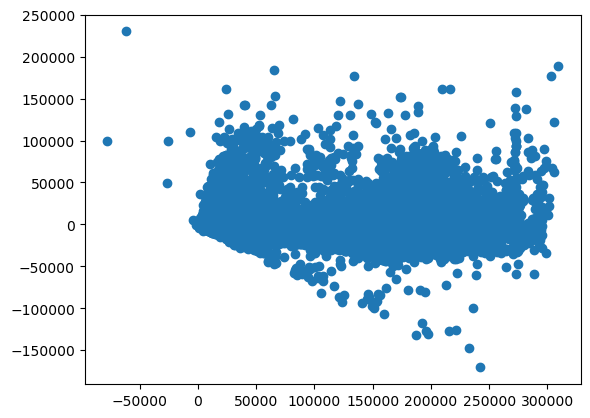

In [ ]:
plt.scatter(model.predict(), model.resid)

# whavter model we have assume it is correct

In [228]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['f-value', 'p-value']
test = sms.het_breuschpagan(model.resid, model.model.exog)
lzip(name, test[2:])

[('f-value', np.float64(362.76943294774765)), ('p-value', np.float64(0.0))]

In [230]:
# model evaluation
features_test_combined_constant = sm.add_constant(features_test_combined)
pred = model.predict(features_test_combined_constant)

r2_score(y_test, pred)

0.9384605505685618

In [231]:
# so final model performance is 0.9384605505685618

In [ ]:
# For each region what is the total   

# 